In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import spacy

import re
import os

In [46]:
nlp = spacy.load('en_core_web_lg')

In [47]:
df = pd.read_csv('./sample-mcd.csv', encoding='latin1')
df = df[['reviewer_id', 'review_time', 'review', 'rating']]

df['rating'] = df['rating'].apply(lambda x: int(x.split(" ")[0]))

print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   reviewer_id  100 non-null    int64 
 1   review_time  100 non-null    object
 2   review       100 non-null    object
 3   rating       100 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 3.3+ KB
None


,reviewer_id,review_time,review,rating
0,1,3 months ago,Why does it look like someone spit on my food?...,1
1,2,5 days ago,It'd McDonalds. It is what it is as far as the...,4
2,3,5 days ago,Made a mobile order got to the speaker and che...,1
3,4,a month ago,My mc. Crispy chicken sandwich was ÃÂ¯ÃÂ¿ÃÂ...,5
4,5,2 months ago,"I repeat my order 3 times in the drive thru, a...",1


In [48]:
# Load Bing Liu's opinion word dictionary
bing_liu_opinion_words = set()  # Add the actual list of opinion words here

# Function to load opinion words from Bing Liu lexicon
def load_opinion_words(filepath):
    global bing_liu_opinion_words
    temp = pd.read_table(filepath, comment=';', header=None)[0].to_list()
    bing_liu_opinion_words = bing_liu_opinion_words.union(set(temp))


# Load opinion words
current_dir = os.getcwd()
load_opinion_words(os.path.join(current_dir, 'util/opinion-lexicon-English/negative-words.txt'))
load_opinion_words(os.path.join(current_dir, 'util/opinion-lexicon-English/positive-words.txt'))

In [49]:
from contractions import CONTRACTION_MAP

##========== PREPARATION TEXT ===========##

# Contraction
def expand_contractions(sentence, contraction_mapping=CONTRACTION_MAP):
    """
    Expand the contractions in a sentence. For example don't => do not.
    
    Paramters:
    sentence (str): The input sentence to clean.
    contraction_mapping (dict): A dictionary for mapping contractions.
    
    
    Returns:
    str: The expanded contraction sentence.
    """
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())),
                                      flags=re.IGNORECASE|re.DOTALL)
    
    def expanded_match(contraction):
        """
        Filter for expanding the matched contraction.
        
        Parameters:
        contraction (str): The input of contraction
        
        Returns:
        str: The expanded contraction.
        """
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match) if contraction_mapping.get(match) else contraction_mapping.get(match.lower())
        
        expanded_contraction = first_char + expanded_contraction[1:]
        return expanded_contraction
    
    expanded_sentence = contractions_pattern.sub(expanded_match, sentence)
    return expanded_sentence


def remove_extra_spaces(sentence):
    # Use regex to replace multiple spaces with a single space
    return re.sub(r'\s+', ' ', sentence).strip()


def remove_non_ascii(text):
    """
    Remove all non-ASCII characters from the text.

    Parameters:
    text (str): The input text to clean.

    Returns:
    str: The cleaned text with only ASCII characters.
    
    """
    
    return ''.join([char for char in text if ord(char) < 128])

In [199]:
##=========== EXTRACT ASPECT ============##
# Cross product two lists
def cross_product_str(first, second):
    """
    Do cross product

    parameters
    -----------
    first: list/string
    second: list/string

    return: list of string
    """
    temp = []
    if type(first) == str:
        first = [first]
    if type(second) == str:
        second = [second]
    for i in first:
        for j in second:
            text = (i + ' ' + j).strip()
            temp.append(text)
    return temp

def cross_product_tuple(first, second):
    """
    Do cross product

    parameters
    -----------
    first: list/string
    second: list/string

    return: list of tuple
    """
    temp = []
    if type(first) == str:
        first = [first]
    if type(second) == str:
        second = [second]
    for i in first:
        for j in second:
            temp.append((i, j))
    return temp

# Get neglection text
def get_neglect(token):
    for t in token.children:
        if (t.dep_ == 'neg') or (t.dep_ == 'det' and t.text.lower() == 'no'):
            return 'not'
    return ''
    
# Get token spcific dependency
def get_token_dep(token, dep):
    if type(dep) == str:
        dep = [dep]
    for t in token.children:
        if t.dep_ in dep:
            return t

    return None

def get_all_token_dep(token, dep):
    result = []
    if type(dep) == str:
        dep = [dep]
    for t in token.children:
        if t.dep_ in dep:
            result.append(t)
    return result

# Get token coordinate conjugation
# def get_token_cc(token):
#     for t in token.children:
#         if t.dep_ == 'cc':
#             return t
#     return None

# Crawling all possibile conjuct
def extract_conj(token, neglect=False, lemma=False):
    result = []
    current = get_token_dep(token, dep='conj')
    while current:
        if neglect:
            neg = get_neglect(current)
            # If lemma
            if lemma:
                text = (neg + ' ' + current.lemma_).strip()
            else:
                text = (neg + ' ' + current.text).strip()
                    
            result.append(text)
        else:
            result.append(current.text)
        current = get_token_dep(current, dep='conj')

    return result

# Get sentences that include coordinating conjunction and its conjuct
def get_text_conj(token):
    # Get all sentence of series include the conjugation
    tokens = [token]
    # Get all token
    tokens += extract_conj(token, all_token=True)

    text = ''
    for i, t in enumerate(tokens):
        text = text + t.text
        if i < len(tokens) - 1:
            if t.dep_ == 'cc':
                text += ' '
            else:
                text += ', '

    # text = text.strip()
    return text

# Crawling all possibile adjective pre-modifier
def extract_pre_adj(token, lemma=False):
    result = []
    current_idx = token.i
    for child in token.children:
        if child.pos_ == 'ADJ' and child.i < current_idx:
            if lemma:
                result.append((child.lemma_, child.i))
            else:
                result.append((child.text, child.i))

    # Sort by its index
    result = sorted(result, key=lambda x: x[1])

    # Return only list of string
    result = [item[0] for item in result]

    return result

# Crawling all possible adjective post-modifier
def extract_post_adj(token, lemma=False):
    result = []
    current_idx = token.i
    for child in token.children:
        if child.pos_ == 'ADJ' and child.i > current_idx:
            if lemma:
                result.append((child.lemma_, child.i))
            else:
                result.append((child.text, child.i))

    # Sort by its index
    result = sorted(result, key=lambda x: x[1])

    # Return only list of string
    result = [item[0] for item in result]

    return result

# Crawling all possible adverb
def extract_adv(token, lemma=True):
    result_pre = []
    result_post = []
    current_idx = token.i
    for child in token.children:
        # If pre-position adverb
        if child.pos_ == 'ADV' and child.i < current_idx:
            if lemma:
                result_pre.append((child.lemma_, child.i))
            else:
                result_pre.append((child.text, child.i))

        # If post-position adverb
        if child.pos_ == 'ADV' and child.i > current_idx:
            if lemma:
                result_post.append((child.lemma_, child.i))
            else:
                result_post.append((child.text, child.i))

    # Sort by its index
    result_pre = sorted(result_pre, key=lambda x: x[1])
    result_post = sorted(result_post, key=lambda x: x[1])

    # Return only list of string
    result_pre = [item[0] for item in result_pre]
    result_post = [item[0] for item in result_post]

    return result_pre, result_post


# # Get the sentence point mapper
# def get_sentence_mapper():
#     sentence_point = {}
#     for i, s in enumerate(doc.sents):
#         sentence_point[i] = (s.start, s.end)
#     return sentence_point
    
# # Get location sentence
# sentence_mapper = get_sentence_mapper(doc)

def get_sentence_location(mapper, position):
    for s in mapper.keys():
        interval = mapper[s]
        if position >= interval[0] and position < interval[1]:
            return s

In [51]:
# Extract all raw aspects
def get_raw_aspects(doc):
    # Define global variables
    global bing_liu_opinion_words
    
    # Define local variables
    storage = []

    # Define helper function
    def is_abnormal_noun(text):
        """
            If text only contains special character/number/both OR total length less than 3 it specified as abnormal.
        """
        if re.match(r'^[0-9\W]+$', token.text) or len(token.text) < 3:
            return True
        else:
            return False

    # Going through all token
    for idx, token in enumerate(doc):
        # Make sure the text is not abnormal
        if is_abnormal_noun(token.text):
            continue

        # If the word is noun and preceded by an adjective
        if idx != 0 and (token.pos_ == 'NOUN' and doc[idx - 1].pos_ == 'ADJ'):
            # If the adjective is an opinion
            if doc[idx - 1].text not in bing_liu_opinion_words:
                # Concatenate adj + word then add to storage
                text = doc[idx - 1].text + ' ' + token.text
                storage.append((text, idx - 1, idx + 1))
            else:
                # Else, add noun only
                text = token.text
                storage.append((text, idx, idx + 1))
            continue
            
        # If the word is noun and preceded by another noun
        if idx != 0 and (token.pos_ == 'NOUN' and doc[idx - 1].pos_ == 'NOUN'):
            text = doc[idx - 1].text + ' ' + token.text
            storage.append((text, idx - 1, idx + 1))
            continue

        # If the word is noun and direct object
        if token.pos_ == 'NOUN' and (token.dep_ == 'dobj'):
            text = token.text
            storage.append((text, idx, idx + 1))
            continue
    
        # If the word is noun and a subject of sentence
        if token.pos_ == 'NOUN' and token.dep_ == 'nsubj':
            text = token.text
            storage.append((text, idx, idx + 1))
            continue
    
        # If the word is noun and a conj of another noun
        if (token.pos_ == 'NOUN' and token.dep_ == 'conj') and (token.head.pos_ == 'NOUN'):
            text = token.text
            storage.append((text, idx, idx + 1))
            continue
    
        # # If the sentence contains SUBJECT VERB, then makes it true
        # if token.dep_ == 'nsubj' and token.head.pos_ == 'VERB':
        #     is_contain_subject_verb = True
    
        # # If token is word that contain pre-modifier
        # if (token.dep_ == 'amod' and token.head.pos_ == 'NOUN'):
        #     if token.head.i != idx + 1:
        #         continue
        #     text = token.text + ' ' + token.head.text
        #     storage.append((text, idx, token.head.i + 1))
    
        # # If token is word that contain post-modifier
        # if (token.dep_ == 'pobj' and token.pos_ == 'NOUN'):
        #     if token.head.dep_ == 'prep' and token.head.head.pos_ == 'NOUN':
        #         text = token.head.head.text + ' ' + token.head.text + ' ' + token.text
        #         start = token.head.head.i
        #         storage.append((text, start, idx + 1))
            
        
        # If token is adverb modifier and its head is NOUN then store it.
        if (token.dep_ == 'advmod' and token.head.pos_ == 'NOUN'):
            text = token.head.text + ' ' + token.text
            storage.append((text, token.head.i, idx + 1))
            # adv_adj_mod.append((text, idx, idx + 1))

    # Sort storage
    storage = list(set(storage))
    storage = sorted(storage, key=lambda x: (x[1], x[0]))

    return storage

# Prunning raw aspect
def prunning_aspect(list_, doc):
    # Define local variables
    drop_idx = []
    storage = {}
    
    # Get sentence mapper and prepare storage
    sentence_points = {}
    for i, s in enumerate(doc.sents):
        sentence_points[i] = (s.start, s.end)
        storage[i] = []

    for idx, item in enumerate(list_):
        # As long as current idx does not more than maximum list_ index
        if idx != len(list_) - 1:
            # Get the next item
            next_item = list_[idx + 1]
            # If current item start position and next item end position are overlapping
            if item[-1] - 1 == next_item[1]:
                # We merge the text based on last text in current item and first text in next item
                append_text = ' '.join(next_item[0].split()[1:])
                # Update next item values
                new_text = item[0] + ' ' + append_text
                new_start = item[1]
                new_end = next_item[-1]
                list_[idx + 1] = (new_text, new_start, new_end)

                # Add current index into dropped index list
                drop_idx.append(idx)
            
            # If current item start position = next item end position (They are next to each other)
            if item[-1] == next_item[1]:
                # Update the next value (do not have to merge the text based on specific text).
                new_text = item[0] + ' ' + next_item[0]
                new_start = item[1]
                new_end = next_item[-1]
                list_[idx + 1] = (new_text, new_start, new_end)

                # Add current index into dropped index list
                drop_idx.append(idx)
                
    list_ = [list_[i] for i in range(len(list_)) if i not in drop_idx]

    # Create return as mapper
    for i, s in enumerate(list_):
        text, start, end = s
        sentence_location = get_sentence_location(sentence_points, start)
        # Update value and store text as lowercase
        storage[sentence_location].append(text.lower())
    return storage

In [52]:
# Generate mapper pronouns-antecedents (subject only)
def get_mapper_pron_ant(doc):
    
    def locate_subject_ant_pron(_doc):
        # Locate potential antecedents and pronouns (subject only)
    
        # Define local variables
        antecedents = []
        pron = []
        prohibit_pronouns = [ 'i', 'you', 'me', 'my', 'mine']
    
        # Get sentence mapper
        sentence_points = {}
        for i, s in enumerate(_doc.sents):
            sentence_points[i] = (s.start, s.end)
        
        for token in _doc:
            # Condition potential antecedents
            # If the token is not pronouns and it's a subject
            if (token.pos_ in ['NOUN', 'PROPN']) and (token.dep_ == 'nsubj'):
                start = token.i
                end = start + 1
                location_sentence = get_sentence_location(sentence_points, start)
                antecedents.append((token, start, location_sentence))
                # Check is there any conj
                # antecedents += extract_conj(token, only_token=True)
        
            # if (token.pos_ != 'PRON') and (token.dep_ == 'dobj' or token.dep_ == 'pobj'):
            #     start = token.i
            #     end = start + 1
            #     location_sentence = get_sentence_location(sentence_points, start)
            #     antecedents.append((token, start, location_sentence))
            #     # Check is there any conj
            #     # antecedents += extract_conj(token, only_token=True)    
        
            # Condition potential pronouns
            # Rule 1
            # If pron is subject (it could be same sentence or previously)
            if (token.pos_ == 'PRON' and token.text.lower() not in prohibit_pronouns) and (token.dep_ == 'nsubj'):
                # start = est_loc - len(token.text)
                # end = est_loc
                # start = ex.index(token.text)
                # end = start + len(token.text)
                start = token.i
                end = start + 1
                location_sentence = get_sentence_location(sentence_points, start)
                pron.append((token, start, location_sentence))
                
            # Rule 2
            # If pron is possesion (ant is subject in the same sentence)
            if (token.pos_ == 'PRON' and token.text.lower() not in prohibit_pronouns) and (token.dep_ == 'poss'):
                # start = est_loc - len(token.text)
                # end = est_loc
                start = token.i
                end = start + 1
                location_sentence = get_sentence_location(sentence_points, start)
                pron.append((token, start, location_sentence))
        
            # Rule 3
            # If pron is object
            # if (token.pos_ == 'PRON') and (token.dep_ == 'dobj' or token.dep_ == 'pobj'):
            #     start = token.i
            #     end = start + 1
            #     location_sentence = get_sentence_location(sentence_points, start)
            #     pron.append((token, start, location_sentence))
        
        
        return (antecedents, pron)

    # Filter sentence
    def filter_sentence(_list, location):
        temp = []
        for e in _list:
            if e[-1] == location:
                temp.append(e)
        return temp

    # Define local variable
    mapper = {}
    result = None

    antecedents, pronouns = locate_subject_ant_pron(doc)
    
    if len(pronouns) > 0:
        for p in pronouns:
            # Current status
            is_success = False

            # Get current text, index token, and location sentence token
            token_pron, index_pron, sent_pron = p
            current_sentence = sent_pron
            
            while current_sentence > -1:
                # Get the antecedents
                filter_antecedents = filter_sentence(antecedents, current_sentence)

                # If the filter antecedents exist
                if len(filter_antecedents) > 0:
                    for ant in filter_antecedents:
                        token_ant, index_ant, sent_ant = ant
                        # If antecedent is subject and pronouns is subject or possession and antecedent on the left of pronoun
                        if ('subj' in token_ant.dep_) and ('subj' in token_pron.dep_ or 'poss' in token_pron.dep_) and (index_ant < index_pron):
                            mapper[index_pron] = index_ant
                            is_success = True
                            break
                        # if ('obj' in token_ant.dep_ and 'obj' in token_pron.dep_) and (index_ant < index_pron):
                        #     mapper[index_pron] = index_ant
                        #     is_success = True
                        #     break
                
                # If already success, break it.
                if is_success:
                    break
                    
                current_sentence -= 1

    return mapper

In [53]:
def get_raw_abilities(doc):
    storage = {}
    first_person_pronouns = [ 'i', 'me', 'my', 'mine', 'we', 'us', 'our', 'ours']

    # Get sentence mapper and prepare storage
    sentence_points = {}
    for i, s in enumerate(doc.sents):
        sentence_points[i] = (s.start, s.end)
        storage[i] = []

    # Get mapper pronoun and antecedents
    mapper_pron_ant = get_mapper_pron_ant(doc)
        
    for idx, token in enumerate(doc):
        subjects = []
        abilities = []
    
        # If the token is verb
        if token.pos_ == 'VERB':
            
            for t in token.children:
                # Check if the token children contain subject.
                if t.dep_ == 'nsubj':
                    # Get current child index and text
                    current_idx = t.i
                    text = t.lemma_
                    # If the current child is first person pronoun
                    if t.pos_ == 'PRON' and t.text.lower() in first_person_pronouns:
                        # The token is reference to "the user"
                        text = 'the user'
                    # If the current child is pronoun and its current_idx in mapper_pron_ant
                    elif t.pos_ == 'PRON' and current_idx in mapper_pron_ant.keys():
                        # Change current token
                        idx_map = mapper_pron_ant[current_idx]
                        t = doc[idx_map]
                        text = t.lemma_
                    # If the current child is pronoun (but not in mapper_pron_ant keys), or only contains special characters or numbers, or
                    #   length text less than 3
                    elif (t.pos_ == 'PRON') or (re.match(r'^[0-9\W]+$', t.text)) or (len(t.text) < 3):
                        continue
                    subjects.append(text)
                    # Looping through the children of subject.
                    subjects += extract_conj(t, lemma=True)

            if len(subjects) > 0:
                # Make sure the subject is unique
                subjects = list(set(subjects))
                
                # Store the result
                result = cross_product_tuple(subjects, token.lemma_)
                # Result should be lowercase
                result = [(s.lower(), a.lower()) for s, a in result]
                sentence_location = get_sentence_location(sentence_points, idx)
                storage[sentence_location] += result
    
    
        # If the token is aux
        elif token.pos_ == 'AUX':
            
            # Looping through children
            for t in token.children:
                if t.dep_ == 'nsubj':
                    # Get current child index and text
                    current_idx = t.i
                    text = t.lemma_
                    # If the current child is pronoun I, me, my
                    if t.pos_ == 'PRON' and t.text.lower() in first_person_pronouns:
                        # The token is reference to "the user"
                        text = 'the user'
                    # If the current child is pronoun and its current_idx in mapper_pron_ant
                    elif t.pos_ == 'PRON' and current_idx in mapper_pron_ant.keys():
                        # Change current token
                        idx_map = mapper_pron_ant[current_idx]
                        t = doc[idx_map]
                        text = t.lemma_
                    # If the current child is pronoun (but not in mapper_pron_ant keys), or only contains special characters or numbers, or
                    #   length text less than 3
                    elif (t.pos_ == 'PRON') or (re.match(r'^[0-9\W]+$', t.text)) or (len(t.text) < 3):
                        continue
                        
                    subjects.append(text)
                    # Looping through the children of subject.
                    subjects += extract_conj(t, lemma=True)

                # Check if the neglect exist and depend on token aux
                neg = get_neglect(token)
                if t.dep_ == 'acomp':
                    # If neglection does not exist after aux, then check if it exist at first adj/verb
                    if not neg:
                        neg = get_neglect(t)
                    abilities.append(t.lemma_)
                    # Looping through the children of subject
                    # If neglection does not appear in after aux or before first subject.
                    #  Then check all neglection in first conjugation.
                    if not neg:
                        abilities += extract_conj(t, neglect=True, lemma=True)
                    else:
                        abilities += extract_conj(t, lemma=True)
                        abilities = cross_product_str(neg, abilities)
    
            if len(subjects) > 0 and len(abilities) > 0 :
                # Make sure the subject is unique
                subjects = list(set(subjects))

                # Store the result
                result = cross_product_tuple(subjects, abilities)
                # Result should be lowercase
                result = [(s.lower(), a.lower()) for s, a in result]
                sentence_location = get_sentence_location(sentence_points, idx)
                storage[sentence_location] += result
            
        # If the token is noun
        elif token.pos_ == 'NOUN':
            # If only contains special characters or numbers, or length text less than 3
            if re.match(r'^[0-9\W]+$', token.text) or len(token.text) < 3:
                continue
            for t in token.lefts:
                if t.pos_ == 'ADJ':
                    neg = get_neglect(t)
                    if neg:
                        abilities.append(neg + ' ' + t.lemma_)
                    else:
                        abilities.append(t.lemma_)
    
            # If the token contain abilities, then we check is there any conjugation
            if len(abilities) > 0:
                subjects.append(token.lemma_)
                subjects += extract_conj(token, lemma=True)
                # Make sure the subject is unique
                subjects = list(set(subjects))


                # Store the result
                result = cross_product_tuple(subjects, abilities)
                # Result should be lowercase
                result = [(s.lower(), a.lower()) for s, a in result]
                sentence_location = get_sentence_location(sentence_points, idx)
                storage[sentence_location] += result

    return storage

In [54]:
def process_ability(x):
    # Prepare sentence
    texts = remove_extra_spaces(x)
    texts = expand_contractions(x)
    texts = remove_non_ascii(x)

    # Get aspect
    doc = nlp(texts)
    mapper_pron_ant = get_mapper_pron_ant(doc)
    result = get_raw_abilities(doc)
    
    return result

text = "Just spent 10 minutes waiting at this McDonald's ." +\
        "According to Google they're open 24/7. Finally we pull up to the window to see if anyone was there," +\
        " sure enough one employee seated in the lobby and another at the window. She told me they were closed." +\
        " Whoever these two are they need to be replaced. Get it together McDonald's. You're a corporate power house and you have a reputation to keep." +\
        "One of the most unprofessional experiences I've ever had with fast food. 0/10 would not recomend this location."
# text = "We hit it off pretty good in the beginning everything was great but that didn" +\
#         "ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯" +\
#         "ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯" +\
#         "ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½t last long. I mean the service is fast but with attitude an"
# text = "Mcdonalds is great but they really need to hire people who understand both english and spanish and not just spanish speakers trying to take english orders. "+\
#         "The people are really nice but be smarter about who you put in the drive thru and lobby to take orders."
sample_ability = process_ability(text)
sample_ability

{0: [],
 1: [('the user', 'pull')],
 2: [],
 3: [],
 4: [],
 5: [('house', 'corporate')],
 6: [('experience', 'unprofessional'), ('the user', 'have'), ('food', 'fast')],
 7: []}

In [55]:
df['review'].iloc[33]

"Just spent 10 minutes waiting at this McDonald's . According to Google they're open 24/7. Finally we pull up to the window to see if anyone was there, sure enough one employee seated in the lobby and another at the window. She told me they were closed. Whoever these two are they need to be replaced. Get it together McDonald's. You're a corporate power house and you have a reputation to keep. One of the most unprofessional experiences I've ever had with fast food. 0/10 would not recomend this location."

In [56]:
def process_aspect(x, mapper_1=None, mapper_2=None): 
    # Prepare sentence
    texts = remove_extra_spaces(x)
    texts = expand_contractions(x)
    texts = remove_non_ascii(x)

    # Get aspect
    doc = nlp(texts)
    result = get_raw_aspects(doc)
    result = prunning_aspect(result, doc)

    return result

text = "Just spent 10 minutes waiting at this McDonald's ." +\
        "According to Google they're open 24/7. Finally we pull up to the window to see if anyone was there," +\
        " sure enough one employee seated in the lobby and another at the window. She told me they were closed." +\
        " Whoever these two are they need to be replaced. Get it together McDonald's. You're a corporate power house and you have a reputation to keep." +\
        "One of the most unprofessional experiences I've ever had with fast food. 0/10 would not recomend this location."
# text = "We hit it off pretty good in the beginning everything was great but that didn" +\
#         "ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯" +\
#         "ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯" +\
#         "ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½t last long. I mean the service is fast but with attitude an"
sample_asp = process_aspect(text)
sample_asp

{0: ['minutes'],
 1: [],
 2: [],
 3: [],
 4: ['mcdonald'],
 5: ['corporate power house', 'reputation'],
 6: ['unprofessional experiences', 'food'],
 7: ['location']}

In [57]:
#### TRY GENSHIM TF-IDF
import gensim
from gensim import corpora
from gensim.models import TfidfModel
from pprint import pprint

# Determine selected word (only words) high TF-IDF (Original word) but low IDF (The most common exist in corpus)

def get_words(corpus, thres_tfidf=90, thres_idf=10):
    # Define local variables
    storage_idf = set()
    storage_tfidf = {}
    
    # Preprocessing text
    def preprocessing(text):
        text = remove_extra_spaces(text)
        text = expand_contractions(text)
        text = remove_non_ascii(text)

        # Get token of words
        doc = nlp(text)
        result = []
        for token in doc:
            t = token.lemma_.lower()

            # If only contains special characters or numbers and length less than 3
            if re.match(r'^[0-9\W]+$', t) or len(t) < 3:
                continue
            else:
                result.append(t)
        return result

    ##========= GENERATE MODEL =========##
    # Create texts
    texts = [preprocessing(document) for document in corpus]

    # Create dictionary
    dictionary = corpora.Dictionary(texts)

    # Convert documents into Bag-of-words format
    corpus_bow = [dictionary.doc2bow(text) for text in texts]

    # Train the TF-IDF model
    tfidf_model = gensim.models.TfidfModel(corpus_bow)

    ##============ EXTRACT IMPORTANT VALUES =========##
    # Get the idf values
    idf_values = tfidf_model.idfs # Return (word_id: idf_values)
    scores_idf = np.array(list(idf_values.values()))
    
    idf_dict = {}
    for id, value in idf_values.items():
        word = dictionary[id]
        idf_dict[word] = value
        

    # Apply the model to the corpus (get corpus tfidf)
    corpus_tfidf = tfidf_model[corpus_bow]

    # Get dictionary of tfidf values and scores
    scores_tfidf = []
    tfidf_dict = {}
    for doc_idx, doc in enumerate(corpus_tfidf):

        dict_doc = {}
        for word_id, score in doc:
            word = dictionary[word_id]
            dict_doc[word] = score
            scores_tfidf.append(score)

        tfidf_dict[doc_idx] = dict_doc
    
    ##=========== Get the threshold =========##
    threshold_idf = np.percentile(scores_idf, thres_idf)
    threshold_tfidf = np.percentile(scores_tfidf, thres_tfidf)


    ##========== Get Words =============##
    # IDF
    for key, value in idf_dict.items():
        if value <= threshold_idf:
            storage_idf.add(key)

    # TF IDF
    for idx_doc, dict_words in tfidf_dict.items():
        temp = set()
        for key, value in dict_words.items():
            if value >= threshold_tfidf:
                temp.add(key)
            
        storage_tfidf[idx_doc] = temp

    return storage_idf, storage_tfidf

documents = df['review'].values

mapper_1, mapper_2 = get_words(documents)

In [58]:
def important_words_aspect(dict_doc, idx_doc, mapper_1=None, mapper_2=None):
    # If mapper_1 and mapper_2 is None, do not filter it.
    if not mapper_1 and not mapper_2:
        return dict_doc

    # Copy dictionary
    dictionary = dict_doc.copy()
    
    # Get mapper based on its document.
    if mapper_2 :
        mapper_2 = mapper_2[idx_doc]

    for key, value in dictionary.items():
        temp = []
        for v1 in value:
            # Since it could be multiple word, we must check one by one
            for v in v1.split():
                # If aspect is in mapper_1 or mapper_2 then keep it
                if v in mapper_1 or v in mapper_2:
                    # Append full value
                    temp.append(v1)
                    break

        # Update list of string
        dictionary[key] = temp
    
    return dictionary

sample_asp = process_aspect(text)
pprint(df['review'].iloc[33])
pprint(sample_asp)
pprint(important_words_aspect(sample_asp, 33, mapper_1=mapper_1, mapper_2=mapper_2))

("Just spent 10 minutes waiting at this McDonald's . According to Google "
 "they're open 24/7. Finally we pull up to the window to see if anyone was "
 'there, sure enough one employee seated in the lobby and another at the '
 'window. She told me they were closed. Whoever these two are they need to be '
 "replaced. Get it together McDonald's. You're a corporate power house and you "
 "have a reputation to keep. One of the most unprofessional experiences I've "
 'ever had with fast food. 0/10 would not recomend this location.')
{0: ['minutes'],
 1: [],
 2: [],
 3: [],
 4: ['mcdonald'],
 5: ['corporate power house', 'reputation'],
 6: ['unprofessional experiences', 'food'],
 7: ['location']}
{0: [],
 1: [],
 2: [],
 3: [],
 4: ['mcdonald'],
 5: [],
 6: ['food'],
 7: ['location']}


In [59]:
def important_words_ability(dict_doc, idx_doc, mapper_1=None, mapper_2=None):
    # If mapper_1 and mapper_2 is None, do not filter it.
    if not mapper_1 and not mapper_2:
        return dict_doc

    # Copy dictionary
    dictionary = dict_doc.copy()
    
    # Get mapper based on its document.
    if mapper_2 :
        mapper_2 = mapper_2[idx_doc]

    for key, value in dictionary.items():
        temp = []
        for s, a in value:
            if s in mapper_1 or s in mapper_2:
                # Append full value
                temp.append((s, a))
                    
        # Update list of string
        dictionary[key] = temp
    
    return dictionary

pprint(df['review'].iloc[33])
pprint(sample_ability)
pprint(important_words_ability(sample_ability, 33, mapper_1=mapper_1, mapper_2=mapper_2))

("Just spent 10 minutes waiting at this McDonald's . According to Google "
 "they're open 24/7. Finally we pull up to the window to see if anyone was "
 'there, sure enough one employee seated in the lobby and another at the '
 'window. She told me they were closed. Whoever these two are they need to be '
 "replaced. Get it together McDonald's. You're a corporate power house and you "
 "have a reputation to keep. One of the most unprofessional experiences I've "
 'ever had with fast food. 0/10 would not recomend this location.')
{0: [],
 1: [('the user', 'pull')],
 2: [],
 3: [],
 4: [],
 5: [('house', 'corporate')],
 6: [('experience', 'unprofessional'), ('the user', 'have'), ('food', 'fast')],
 7: []}
{0: [],
 1: [],
 2: [],
 3: [],
 4: [],
 5: [],
 6: [('experience', 'unprofessional'), ('food', 'fast')],
 7: []}


In [60]:
def process_aspect(x, idx, mapper_1=None, mapper_2=None): 
    # Prepare sentence
    texts = remove_extra_spaces(x)
    texts = expand_contractions(x)
    texts = remove_non_ascii(x)

    # Get aspect
    doc = nlp(texts)
    result = get_raw_aspects(doc)
    result = prunning_aspect(result, doc)
    result = important_words_aspect(result, idx_doc=idx, mapper_1=mapper_1, mapper_2=mapper_2)
    return result

text = "Just spent 10 minutes waiting at this McDonald's ." +\
        "According to Google they're open 24/7. Finally we pull up to the window to see if anyone was there," +\
        " sure enough one employee seated in the lobby and another at the window. She told me they were closed." +\
        " Whoever these two are they need to be replaced. Get it together McDonald's. You're a corporate power house and you have a reputation to keep." +\
        "One of the most unprofessional experiences I've ever had with fast food. 0/10 would not recomend this location."
# text = "We hit it off pretty good in the beginning everything was great but that didn" +\
#         "ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯" +\
#         "ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯" +\
#         "ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½t last long. I mean the service is fast but with attitude an"
process_aspect(text, 33, mapper_1, mapper_2)

{0: [],
 1: [],
 2: [],
 3: [],
 4: ['mcdonald'],
 5: [],
 6: ['food'],
 7: ['location']}

In [61]:
def process_ability(x, idx, mapper_1=None, mapper_2=None):
    # Prepare sentence
    texts = remove_extra_spaces(x)
    texts = expand_contractions(x)
    texts = remove_non_ascii(x)

    # Get aspect
    doc = nlp(texts)
    result = get_raw_abilities(doc)
    result = important_words_ability(result, idx_doc=idx, mapper_1=mapper_1, mapper_2=mapper_2)
    
    return result

text = "Just spent 10 minutes waiting at this McDonald's ." +\
        "According to Google they're open 24/7. Finally we pull up to the window to see if anyone was there," +\
        " sure enough one employee seated in the lobby and another at the window. She told me they were closed." +\
        " Whoever these two are they need to be replaced. Get it together McDonald's. You're a corporate power house and you have a reputation to keep." +\
        "One of the most unprofessional experiences I've ever had with fast food. 0/10 would not recomend this location."
# text = "We hit it off pretty good in the beginning everything was great but that didn" +\
#         "ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯" +\
#         "ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯" +\
#         "ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½t last long. I mean the service is fast but with attitude an"
# text = "Mcdonalds is great but they really need to hire people who understand both english and spanish and not just spanish speakers trying to take english orders. "+\
#         "The people are really nice but be smarter about who you put in the drive thru and lobby to take orders."
process_ability(text, 33, mapper_1, mapper_2)

{0: [],
 1: [],
 2: [],
 3: [],
 4: [],
 5: [],
 6: [('experience', 'unprofessional'), ('food', 'fast')],
 7: []}

In [62]:
# def process(x):
#     # Prepare sentence
#     texts = remove_extra_spaces(x)
#     texts = expand_contractions(x)
#     texts = remove_non_ascii(x)

#     # Get aspect
#     doc = nlp(texts)
#     temp = []
#     for token in doc:
#         if token.pos_ == 'ADJ':
#     result = get_raw_abilities(doc)
#     result = important_words_ability(result, idx_doc=idx, mapper_1=mapper_1, mapper_2=mapper_2)
    
#     return result

In [63]:
df['aspect'] = [process_aspect(text, i, mapper_1, mapper_2) for i, text in enumerate(df['review'].values)]
df.head()

,reviewer_id,review_time,review,rating,aspect
0,1,3 months ago,Why does it look like someone spit on my food?...,1,"{0: [], 1: ['normal transaction'], 2: ['substa..."
1,2,5 days ago,It'd McDonalds. It is what it is as far as the...,4,"{0: [], 1: ['food', 'atmosphere'], 2: ['staff ..."
2,3,5 days ago,Made a mobile order got to the speaker and che...,1,"{0: ['mobile order'], 1: ['line'], 2: [], 3: [..."
3,4,a month ago,My mc. Crispy chicken sandwich was ÃÂ¯ÃÂ¿ÃÂ...,5,"{0: [], 1: ['crispy chicken sandwich', 'custom..."
4,5,2 months ago,"I repeat my order 3 times in the drive thru, a...",1,"{0: ['order', 'large meal double filet', 'larg..."


In [64]:
df['ability'] = [process_ability(text, i, mapper_1, mapper_2) for i, text in enumerate(df['review'].values)]
df.head()

,reviewer_id,review_time,review,rating,aspect,ability
0,1,3 months ago,Why does it look like someone spit on my food?...,1,"{0: [], 1: ['normal transaction'], 2: ['substa...","{0: [], 1: [('transaction', 'normal')], 2: [('..."
1,2,5 days ago,It'd McDonalds. It is what it is as far as the...,4,"{0: [], 1: ['food', 'atmosphere'], 2: ['staff ...","{0: [], 1: [('food', 'go'), ('atmosphere', 'go..."
2,3,5 days ago,Made a mobile order got to the speaker and che...,1,"{0: ['mobile order'], 1: ['line'], 2: [], 3: [...","{0: [('order', 'mobile'), ('order', 'get')], 1..."
3,4,a month ago,My mc. Crispy chicken sandwich was ÃÂ¯ÃÂ¿ÃÂ...,5,"{0: [], 1: ['crispy chicken sandwich', 'custom...","{0: [], 1: [('sandwich', 'crispy'), ('service'..."
4,5,2 months ago,"I repeat my order 3 times in the drive thru, a...",1,"{0: ['order', 'large meal double filet', 'larg...","{0: [('filet', 'double'), ('fry', 'large')], 1..."


In [65]:
df[['review', 'aspect', 'ability']]

,review,aspect,ability
0,Why does it look like someone spit on my food?...,"{0: [], 1: ['normal transaction'], 2: ['substa...","{0: [], 1: [('transaction', 'normal')], 2: [('..."
1,It'd McDonalds. It is what it is as far as the...,"{0: [], 1: ['food', 'atmosphere'], 2: ['staff ...","{0: [], 1: [('food', 'go'), ('atmosphere', 'go..."
2,Made a mobile order got to the speaker and che...,"{0: ['mobile order'], 1: ['line'], 2: [], 3: [...","{0: [('order', 'mobile'), ('order', 'get')], 1..."
3,My mc. Crispy chicken sandwich was ÃÂ¯ÃÂ¿ÃÂ...,"{0: [], 1: ['crispy chicken sandwich', 'custom...","{0: [], 1: [('sandwich', 'crispy'), ('service'..."
4,"I repeat my order 3 times in the drive thru, a...","{0: ['order', 'large meal double filet', 'larg...","{0: [('filet', 'double'), ('fry', 'large')], 1..."
...,...,...,...
95,If I could give negative stars I would. This l...,"{0: [], 1: ['location'], 2: ['single time'], 3...","{0: [], 1: [], 2: [('time', 'single')], 3: [('..."
96,When ordering food the employees conveniently ...,"{0: ['food'], 1: [], 2: []}","{0: [('employee', 'forget'), ('employee', 'unp..."
97,I donÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯Ã...,"{0: ['location', 'service'], 1: [], 2: []}","{0: [('location', 'have'), ('service', 'rude')..."
98,Allways has the best Fries and Ice cream in th...,{0: ['cream']},"{0: [('allway', 'have'), ('cream', 'good')]}"


In [66]:
# df.to_excel("delete.xlsx", index=False)

In [67]:
# text = "Just spent 10 minutes waiting at this McDonald's ." +\
#         "According to Google they're open 24/7. Finally we pull up to the window to see if anyone was there," +\
#         " sure enough one employee seated in the lobby and another at the window. She told me they were closed." +\
#         " Whoever these two are they need to be replaced. Get it together McDonald's. You're a corporate power house and you have a reputation to keep." +\
#         "One of the most unprofessional experiences I've ever had with fast food. 0/10 would not recomend this location."
text = "I'm not really a huge fan of fast food, but I have 2 teenage daughter's who enjoy McDs. The staff here is always friendly and ALWAYS get their orders correct."+\
        " By far one of the best McDs I have ever been to. I always enjoy and appreciate quality service from quality people... and you'll definitely find it here. "+\
        "At least from the evening crew. Haven't been here during the day. My girls joke that I go here so often to get them food, that the staff is going to end up knowing me"+\
        " and having their order ready to go. Lmao Great people and excellent service. ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯"
idx = 10
doc = nlp(text)
doc

I'm not really a huge fan of fast food, but I have 2 teenage daughter's who enjoy McDs. The staff here is always friendly and ALWAYS get their orders correct. By far one of the best McDs I have ever been to. I always enjoy and appreciate quality service from quality people... and you'll definitely find it here. At least from the evening crew. Haven't been here during the day. My girls joke that I go here so often to get them food, that the staff is going to end up knowing me and having their order ready to go. Lmao Great people and excellent service. ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯

In [68]:
from spacy import displacy

displacy.render(doc, 'dep')

In [69]:
def process_ability(x, idx, mapper_1=None, mapper_2=None):
    # Prepare sentence
    texts = remove_extra_spaces(x)
    texts = expand_contractions(x)
    texts = remove_non_ascii(x)

    # Get aspect
    doc = nlp(texts)
    result = get_raw_abilities(doc)
    result = important_words_ability(result, idx_doc=idx, mapper_1=mapper_1, mapper_2=mapper_2)
    
    return result


for idx, sent in enumerate(doc.sents):
    print(idx, sent)

process_ability(text, idx)

0 I'm not really a huge fan of fast food, but I have 2 teenage daughter's who enjoy McDs.
1 The staff here is always friendly and ALWAYS get their orders correct.
2 By far one of the best McDs I have ever been to.
3 I always enjoy and appreciate quality service from quality people... and you'll definitely find it here.
4 At least from the evening crew.
5 Haven't been here during the day.
6 My girls joke that I go here so often to get them food, that the staff is going to end up knowing me and having their order ready to go.
7 Lmao Great people and excellent service.
8 ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯


{0: [('fan', 'huge'),
  ('food', 'fast'),
  ('the user', 'have'),
  ('daughter', 'teenage')],
 1: [('staff', 'friendly')],
 2: [('mcds', 'good')],
 3: [('the user', 'enjoy')],
 4: [],
 5: [],
 6: [('girl', 'joke'), ('the user', 'go'), ('staff', 'go')],
 7: [('service', 'great'), ('people', 'great'), ('service', 'excellent')]}

In [70]:
#=============== SENTIMENT ANALYSIS ====================#
from pattern.en import sentiment

def pattern_lexicon_model(text, threshold=0.1):

    # Preprocessing text
    def preprocessing(text):
        text = remove_extra_spaces(text)
        text = expand_contractions(text)
        text = remove_non_ascii(text)
        return text

    text = preprocessing(text)
    analysis = sentiment(text)
    sentiment_score = round(analysis[0], 2)
    sentiment_subjectivity = round(analysis[0], 2)
    
    final_sentiment = 'positive' if sentiment_score >= threshold else 'negative'
    
    return final_sentiment


def get_sentiment(text, threshold=0.1):
    # Define local variable
    storage = {}
    
    doc = nlp(text)
    for idx, sentence in enumerate(doc.sents):
        print(idx, sentence.text)
        storage[idx] = pattern_lexicon_model(sentence.text, threshold=threshold)

    return storage

# pprint(text)
get_sentiment(text)

0 I'm not really a huge fan of fast food, but I have 2 teenage daughter's who enjoy McDs.
1 The staff here is always friendly and ALWAYS get their orders correct.
2 By far one of the best McDs I have ever been to.
3 I always enjoy and appreciate quality service from quality people... and you'll definitely find it here.
4 At least from the evening crew.
5 Haven't been here during the day.
6 My girls joke that I go here so often to get them food, that the staff is going to end up knowing me and having their order ready to go.
7 Lmao Great people and excellent service.
8 ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯


{0: 'positive',
 1: 'positive',
 2: 'positive',
 3: 'positive',
 4: 'negative',
 5: 'negative',
 6: 'positive',
 7: 'positive',
 8: 'negative'}

In [71]:
# Get all aspect

def get_all_aspect(list_):
    temp = set()
    for data in list_:
        for values in data.values():
            for value in values:
                temp.add(value)
    return temp

all_aspects = get_all_aspect(df['aspect'].values)

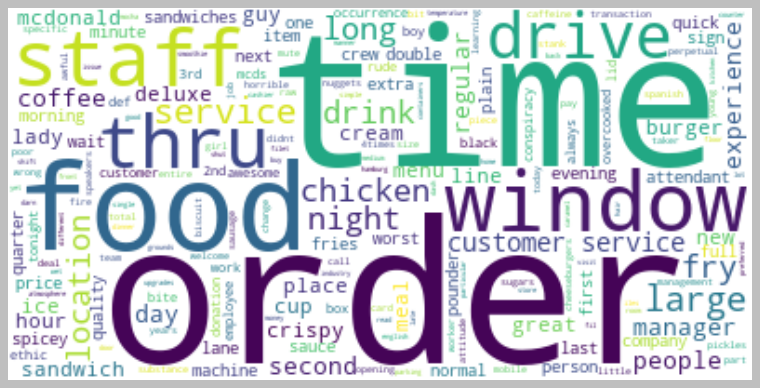

In [72]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = ""
for aspect in all_aspects:
    text = text + " " + aspect
    

text = text.strip()

wordcloud = WordCloud(background_color='white').generate(text)
plt.style.use('classic')
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [226]:
# Preprocessing text
def preprocessing(text):
    text = remove_extra_spaces(text)
    text = expand_contractions(text)
    text = remove_non_ascii(text)
    return text



In [227]:
def get_raw_abilities(doc):
    storage = {}
    first_person_pronouns = [ 'i', 'me', 'my', 'mine', 'we', 'us', 'our', 'ours']

    # Get sentence mapper and prepare storage
    sentence_points = {}
    for i, s in enumerate(doc.sents):
        sentence_points[i] = (s.start, s.end)
        storage[i] = []

    # Get mapper pronoun and antecedents
    mapper_pron_ant = get_mapper_pron_ant(doc)
        
    for idx, token in enumerate(doc):
        subjects = []
        abilities = []
    
        # If the token is verb
        if token.pos_ == 'VERB':
            
            for t in token.children:
                # Check if the token children contain subject.
                if t.dep_ == 'nsubj':
                    # Get current child index and text
                    current_idx = t.i
                    text = t.lemma_
                    # If the current child is first person pronoun
                    if t.pos_ == 'PRON' and t.text.lower() in first_person_pronouns:
                        # The token is reference to "the user"
                        text = 'the user'
                    # If the current child is pronoun and its current_idx in mapper_pron_ant
                    elif t.pos_ == 'PRON' and current_idx in mapper_pron_ant.keys():
                        # Change current token
                        idx_map = mapper_pron_ant[current_idx]
                        t = doc[idx_map]
                        text = t.lemma_
                    # If the current child is pronoun (but not in mapper_pron_ant keys), or only contains special characters or numbers, or
                    #   length text less than 3
                    elif (t.pos_ == 'PRON') or (re.match(r'^[0-9\W]+$', t.text)) or (len(t.text) < 3):
                        continue
                    subjects.append(text)
                    # Looping through the children of subject.
                    subjects += extract_conj(t, lemma=True)

            if len(subjects) > 0:
                # Make sure the subject is unique
                subjects = list(set(subjects))
                
                # Store the result
                result = cross_product_tuple(subjects, token.lemma_)
                # Result should be lowercase
                result = [(s.lower(), a.lower()) for s, a in result]
                sentence_location = get_sentence_location(sentence_points, idx)
                storage[sentence_location] += result
    
    
        # If the token is aux
        elif token.pos_ == 'AUX':
            
            # Looping through children
            for t in token.children:
                if t.dep_ == 'nsubj':
                    # Get current child index and text
                    current_idx = t.i
                    text = t.lemma_
                    # If the current child is pronoun I, me, my
                    if t.pos_ == 'PRON' and t.text.lower() in first_person_pronouns:
                        # The token is reference to "the user"
                        text = 'the user'
                    # If the current child is pronoun and its current_idx in mapper_pron_ant
                    elif t.pos_ == 'PRON' and current_idx in mapper_pron_ant.keys():
                        # Change current token
                        idx_map = mapper_pron_ant[current_idx]
                        t = doc[idx_map]
                        text = t.lemma_
                    # If the current child is pronoun (but not in mapper_pron_ant keys), or only contains special characters or numbers, or
                    #   length text less than 3
                    elif (t.pos_ == 'PRON') or (re.match(r'^[0-9\W]+$', t.text)) or (len(t.text) < 3):
                        continue
                        
                    subjects.append(text)
                    # Looping through the children of subject.
                    subjects += extract_conj(t, lemma=True)

                # Check if the neglect exist and depend on token aux
                neg = get_neglect(token)
                if t.dep_ == 'acomp':
                    # If neglection does not exist after aux, then check if it exist at first adj/verb
                    if not neg:
                        neg = get_neglect(t)
                    abilities.append(t.lemma_)
                    # Looping through the children of subject
                    # If neglection does not appear in after aux or before first subject.
                    #  Then check all neglection in first conjugation.
                    if not neg:
                        abilities += extract_conj(t, neglect=True, lemma=True)
                    else:
                        abilities += extract_conj(t, lemma=True)
                        abilities = cross_product_str(neg, abilities)
    
            if len(subjects) > 0 and len(abilities) > 0 :
                # Make sure the subject is unique
                subjects = list(set(subjects))

                # Store the result
                result = cross_product_tuple(subjects, abilities)
                # Result should be lowercase
                result = [(s.lower(), a.lower()) for s, a in result]
                sentence_location = get_sentence_location(sentence_points, idx)
                storage[sentence_location] += result
            
        # If the token is noun
        elif token.pos_ == 'NOUN':
            # If only contains special characters or numbers, or length text less than 3
            if re.match(r'^[0-9\W]+$', token.text) or len(token.text) < 3:
                continue
            for t in token.lefts:
                if t.pos_ == 'ADJ':
                    neg = get_neglect(t)
                    if neg:
                        abilities.append(neg + ' ' + t.lemma_)
                    else:
                        abilities.append(t.lemma_)
    
            # If the token contain abilities, then we check is there any conjugation
            if len(abilities) > 0:
                subjects.append(token.lemma_)
                subjects += extract_conj(token, lemma=True)
                # Make sure the subject is unique
                subjects = list(set(subjects))


                # Store the result
                result = cross_product_tuple(subjects, abilities)
                # Result should be lowercase
                result = [(s.lower(), a.lower()) for s, a in result]
                sentence_location = get_sentence_location(sentence_points, idx)
                storage[sentence_location] += result

    return storage

In [228]:
# import spacy

# # Load the spaCy model
# nlp = spacy.load("en_core_web_sm")

def extract_ability_property(doc):
    # doc = nlp(text)
    results = []
    
    for token in doc:
        # Check for noun/pronoun subjects
        if token.dep_ in ("nsubj", "nsubjpass"):
            subject = token.text
            
            # Check for verb indicating ability (auxiliary + ROOT)
            if token.head.pos_ == "VERB" and any(child.dep_ == "aux" for child in token.head.children):
                verb = token.head.text
                results.append((subject, f"can {verb}"))
            
            # Check for adjectives or adverbs indicating property
            for child in token.head.children:
                if child.dep_ in ("acomp", "advmod"):
                    property_ = child.text
                    results.append((subject, property_))
        
        # Check for noun/pronoun objects
        if token.dep_ == "dobj":
            obj = token.text
            
            # Check if object has any descriptive adjectives
            for child in token.children:
                if child.dep_ == "amod":  # adjectival modifier
                    property_ = child.text
                    results.append((obj, property_))
    
        # Check for relative clauses, nominal modifiers, and prepositional phrases
        for child in token.head.children:
            if child.dep_ == "relcl" or child.dep_ == "acl":
                property_ = child.text
                results.append((token.text, property_))
                
    return results

In [229]:
# Test sentences
sentence1 = "The dog can run fast."
sentence2 = "The chef cooked a delicious meal."

docex = nlp(sentence1)
displacy.render(docex, 'dep')
print("Algorithm 1: ", get_raw_abilities(docex))
print("Algorithm 2: ", extract_ability_property(docex))  # Output: [('dog', 'can run'), ('dog', 'fast')]

docex = nlp(sentence2)
displacy.render(docex, 'dep')
print("Algorithm 1: ", get_raw_abilities(docex))
print("Algorithm 2: ", extract_ability_property(docex))  # Output: [('chef', 'cooked'), ('meal', 'delicious')]

Algorithm 1:  {0: [('dog', 'run')]}
Algorithm 2:  [('dog', 'can run'), ('dog', 'fast')]


Algorithm 1:  {0: [('chef', 'cook'), ('meal', 'delicious')]}
Algorithm 2:  [('meal', 'delicious')]


In [230]:
sentences = [
    "The cat can jump.",
    "The phone has a camera.",
    "Water can freeze.",
    "This car is fast.",
    "The sun gives light.",
    "The dog has sharp teeth.",
    "The computer can store data.",
    "My bike is lightweight.",
    "The wind can blow hard.",
    "Glass can break easily.",
    "The plant grows quickly.",
    "This material is waterproof.",
    "Birds can fly long distances.",
    "The phone charges wirelessly.",
    "This app automatically tracks your steps.",
    "The engine runs efficiently in cold weather.",
    "His voice carries across the room.",
    "Some animals can camouflage themselves.",
    "The robot is capable of learning new tasks.",
    "The building withstands strong earthquakes.",
    "This software adapts to user behavior over time.",
    "The bridge supports heavy loads without bending.",
    "The new processor processes data faster than previous models.",
    "These shoes reduce the impact on joints while running.",
    "The satellite transmits signals across continents.",
    "The medicine has anti-inflammatory properties.",
    "Solar panels convert sunlight into electricity efficiently.",
    "The AI system can predict stock market trends accurately.",
    "The genetic algorithm optimizes solutions for complex problems.",
    "The spacecraft is designed to sustain life for extended missions."
]


for s in sentences:
    print("Sentence: ", s)
    sample = s
    docex = nlp(sample)
    displacy.render(docex, 'dep')
    print("Algorithm 1: ", get_raw_abilities(docex))
    print("Algorithm 2: ", extract_ability_property(docex))
    print("\n\n\n")

Sentence:  The cat can jump.


Algorithm 1:  {0: [('cat', 'jump')]}
Algorithm 2:  [('cat', 'can jump')]




Sentence:  The phone has a camera.


Algorithm 1:  {0: [('phone', 'have')]}
Algorithm 2:  []




Sentence:  Water can freeze.


Algorithm 1:  {0: [('water', 'freeze')]}
Algorithm 2:  [('Water', 'can freeze')]




Sentence:  This car is fast.


Algorithm 1:  {0: [('car', 'fast')]}
Algorithm 2:  [('car', 'fast')]




Sentence:  The sun gives light.


Algorithm 1:  {0: [('sun', 'give')]}
Algorithm 2:  []




Sentence:  The dog has sharp teeth.


Algorithm 1:  {0: [('dog', 'have'), ('tooth', 'sharp')]}
Algorithm 2:  [('teeth', 'sharp')]




Sentence:  The computer can store data.


Algorithm 1:  {0: [('computer', 'store')]}
Algorithm 2:  [('computer', 'can store')]




Sentence:  My bike is lightweight.


Algorithm 1:  {0: [('bike', 'lightweight')]}
Algorithm 2:  [('bike', 'lightweight')]




Sentence:  The wind can blow hard.


Algorithm 1:  {0: [('wind', 'blow')]}
Algorithm 2:  [('wind', 'can blow'), ('wind', 'hard')]




Sentence:  Glass can break easily.


Algorithm 1:  {0: [('glass', 'break')]}
Algorithm 2:  [('Glass', 'can break'), ('Glass', 'easily')]




Sentence:  The plant grows quickly.


Algorithm 1:  {0: [('plant', 'grow')]}
Algorithm 2:  [('plant', 'quickly')]




Sentence:  This material is waterproof.


Algorithm 1:  {0: [('material', 'waterproof')]}
Algorithm 2:  [('material', 'waterproof')]




Sentence:  Birds can fly long distances.


Algorithm 1:  {0: [('bird', 'fly'), ('distance', 'long')]}
Algorithm 2:  [('Birds', 'can fly'), ('distances', 'long')]




Sentence:  The phone charges wirelessly.


Algorithm 1:  {0: []}
Algorithm 2:  []




Sentence:  This app automatically tracks your steps.


Algorithm 1:  {0: [('app', 'track')]}
Algorithm 2:  [('app', 'automatically')]




Sentence:  The engine runs efficiently in cold weather.


Algorithm 1:  {0: [('engine', 'run'), ('weather', 'cold')]}
Algorithm 2:  [('engine', 'efficiently')]




Sentence:  His voice carries across the room.


Algorithm 1:  {0: [('voice', 'carry')]}
Algorithm 2:  []




Sentence:  Some animals can camouflage themselves.


Algorithm 1:  {0: [('animal', 'camouflage')]}
Algorithm 2:  [('animals', 'can camouflage')]




Sentence:  The robot is capable of learning new tasks.


Algorithm 1:  {0: [('robot', 'capable'), ('task', 'new')]}
Algorithm 2:  [('robot', 'capable'), ('tasks', 'new')]




Sentence:  The building withstands strong earthquakes.


Algorithm 1:  {0: [('building', 'withstand'), ('earthquake', 'strong')]}
Algorithm 2:  [('earthquakes', 'strong')]




Sentence:  This software adapts to user behavior over time.


Algorithm 1:  {0: [('software', 'adapt')]}
Algorithm 2:  []




Sentence:  The bridge supports heavy loads without bending.


Algorithm 1:  {0: [('bridge', 'support'), ('load', 'heavy')]}
Algorithm 2:  [('loads', 'heavy')]




Sentence:  The new processor processes data faster than previous models.


Algorithm 1:  {0: [('processor', 'new'), ('processor', 'process'), ('model', 'previous')]}
Algorithm 2:  [('processor', 'faster')]




Sentence:  These shoes reduce the impact on joints while running.


Algorithm 1:  {0: [('shoe', 'reduce')]}
Algorithm 2:  []




Sentence:  The satellite transmits signals across continents.


Algorithm 1:  {0: [('satellite', 'transmit')]}
Algorithm 2:  []




Sentence:  The medicine has anti-inflammatory properties.


Algorithm 1:  {0: [('medicine', 'have'), ('property', 'anti'), ('property', '-'), ('property', 'inflammatory')]}
Algorithm 2:  [('properties', 'anti'), ('properties', '-'), ('properties', 'inflammatory')]




Sentence:  Solar panels convert sunlight into electricity efficiently.


Algorithm 1:  {0: [('panel', 'solar'), ('panel', 'convert')]}
Algorithm 2:  [('panels', 'efficiently')]




Sentence:  The AI system can predict stock market trends accurately.


Algorithm 1:  {0: [('system', 'predict')]}
Algorithm 2:  [('system', 'can predict'), ('system', 'accurately')]




Sentence:  The genetic algorithm optimizes solutions for complex problems.


Algorithm 1:  {0: [('algorithm', 'genetic'), ('algorithm', 'optimize'), ('problem', 'complex')]}
Algorithm 2:  []




Sentence:  The spacecraft is designed to sustain life for extended missions.


Algorithm 1:  {0: [('mission', 'extended')]}
Algorithm 2:  []






In [231]:
def crawling_after_token_prep_phrase(token):
    result = []
    basis_idx = token.i
    prep = get_all_token_dep(token, dep='prep')
    if prep:
        # If contain children: dep pcomp dep VERB pos tag; Until reach dobj or pobj
        for p in prep:
            prep_idx = p.i
            # If the preposition on the left basis token index, continue
            if basis_idx > prep_idx:
                continue
                
            current = get_token_dep(p, dep=['pcomp', 'dobj', 'pobj'])
            temp = [(p.text, prep_idx)]
            while current:
                text = current.text
                # If current token is object, get the pre-modifier adjective
                if current.dep_ in ['dobj', 'pobj']:
                    pre_adj = ' '.join(extract_pre_adj(current))
                    text = cross_product_str(pre_adj, text)[0]
                    
                temp.append((text, current.i))
                current = get_token_dep(current, dep=['pcomp', 'dobj', 'pobj'])

            temp = sorted(temp, key=lambda x: x[1])
            temp = " ".join([t[0] for t in temp])

            result.append(temp)
            
    return result

# def extract_pre_adj(token, lemma=False):
#     result = []
#     current_idx = token.i
#     for child in token.children:
#         if child.pos_ == 'ADJ' and child.i < current_idx:
#             if lemma:
#                 result.append((child.lemma_, child.i))
#             else:
#                 result.append((child.text, child.i))

#     # Sort by its index
#     result = sorted(result, key=lambda x: x[1])

#     # Return only list of string
#     result = [item[0] for item in result]

#     return result

In [249]:
# storage = {}
# first_person_pronouns = [ 'i', 'me', 'my', 'mine', 'we', 'us', 'our', 'ours']

# # Get sentence mapper and prepare storage
# sentence_points = {}
# for i, s in enumerate(doc.sents):
#     sentence_points[i] = (s.start, s.end)
#     storage[i] = []

# # Get mapper pronoun and antecedents
# mapper_pron_ant = get_mapper_pron_ant(doc)

import pandas as pd
data_verb = pd.read_csv('verb_transitivity.tsv', sep='\t')

map_verb_intrans = data_verb[['verb', 'percent_intrans']].set_index('verb').to_dict()['percent_intrans']


# sample = "This software adapts to user behavior over time."
# sample = "The engine runs efficiently in cold weather"
# sample = "His voice carries across the room"
# sample = "Glass can break easily"
# sample = "The sun gives light" 
# sample = "The robot is capable of learning new tasks."
sample = "She quickly ran gracefully through the forest."

doc = nlp(sample)

def get_raw_abilities_new(doc):
    # Define local variable.
    result = []
    for idx, token in enumerate(doc):
        abilities = []
        
        # If token is subject
        if token.dep_ in ['nsubj', 'nsubjpass']:
            # Go to its head
            head = token.head

            # If head is Verb
            if head.pos_ == 'VERB':
                # Rule 2 and 5: If the verb is posession
                if head.lemma_ == 'have':
                    
                    # Get direct object
                    obj = get_token_dep(head, dep='dobj')
                    
                    # If direct object exist
                    if obj:
                        # Extract all possible pre-modifier adjectives
                        pre_adj_text = ' '.join(extract_pre_adj(obj))
                        
                        # Store object text: If the pre-modifier adjectives do not exist the whitespace will be stripped out
                        ability = cross_product_str(pre_adj_text, obj.text)
                        ability = cross_product_str(head.lemma_, ability)
                        
                        # Add the ability into abilities
                        abilities = abilities + ability
                        
                        # result = (token.lemma_, head.lemma_ + ' ' + obj_text)
    
                    # If the verb is posession but do not have direct object (object that the subject posessed) continue
                    else:
                        continue
                else:
                    # Get aux
                    aux = get_token_dep(head, dep='aux')
        
                    # Get Pre and post adv
                    pre_adv, post_adv = extract_adv(head)
                    pre_adv = (' '.join(pre_adv)).strip()
                    post_adv = (' '.join(post_adv)).strip()
        
                    # Get Preposition after verb
                    prep_after_verb = crawling_after_token_prep_phrase(head)
                    
                    # Extract intransitive rate
                    int_rate = map_verb_intrans.get(head.text) or map_verb_intrans.get(head.lemma_)
        
                    # If the verb is not in the mapper ( we assume it is transitive verb )
                    if not int_rate:
                        int_rate = 0
        
                    
                    # Rules 1 and 6
                    if int_rate >= 0.5:
                        # Store ability
                        ability = cross_product_str(pre_adv, head.text)
                        ability = cross_product_str(ability, post_adv)
                        
                        # If aux exist, add the text into ability_text
                        if aux:
                            ability = cross_product_str(aux.text, ability)
        
                        abilities = abilities + ability
        
                        if prep_after_verb:
                            # Store ability
                            ability = cross_product_str(pre_adv, head.text)
                            ability = cross_product_str(ability, prep_after_verb)
                            
                            abilities = abilities + ability
        
                    # Rules 4 and 7
                    else:
                        # Get the direct object
                        obj = get_token_dep(head, dep='dobj')
        
                        # If the direct object exist
                        if obj:                            
                            ability = cross_product_str(pre_adv, head.text)
                            # If aux exist, add the text into ability_text
                            if aux:
                                ability = cross_product_str(aux.text, ability)

                            # Get pre adjective modifier direct object
                            pre_adj = ' '.join(extract_pre_adj(obj))
                            ability = cross_product_str(ability, pre_adj)
                            ability = cross_product_str(ability, obj.text)
                            
                            abilities = abilities + ability
                        if prep_after_verb:
                            # If direct object does not exist, try catch the preposition phrase
                            ability = cross_product_str(pre_adv, head.text)
                            
                            ability = cross_product_str(ability, prep_after_verb)
                            abilities = abilities + ability
                        if post_adv:
                            ability = cross_product_str(pre_adv, head.text)
                            ability = cross_product_str(ability, post_adv)
                            abilities = abilities + ability
    
            # Rule 2 and 10
            elif head.pos_ == 'AUX':
                # Get the token
                adj_token = get_token_dep(head, dep='acomp')
                # Get all possible adjective after aux
                post_adj = ' '.join(extract_post_adj(head))
                
                # Get Preposition after verb
                prep_after_adj = ' '.join(crawling_after_token_prep_phrase(adj_token))
        
                # Extract ability
                ability = cross_product_str(head.text, post_adj)
                ability = cross_product_str(ability, prep_after_adj)
        
                abilities = abilities + ability

        # Store final result
        if len(abilities) > 0:
            result = result + cross_product_tuple(token.text, abilities)

    return result

get_raw_abilities_new(doc)

# NOTE: This model is not good enough for subject passive. (should update it)

[('She', 'quickly ran gracefully'), ('She', 'quickly ran through forest')]

In [246]:
# Potential more than one: (1) Prepositional phrase (2) Subject (3) Object (4) Ability ==> Verb + adv or Verb + Prep + object

In [250]:
for s in sentences:
    print("Sentence: ", s)
    sample = s
    docex = nlp(sample)
    displacy.render(docex, 'dep')
    print("Algorithm 1: ", get_raw_abilities(docex))
    print("Algorithm 2: ", extract_ability_property(docex))
    print("Algorithm new: ", get_raw_abilities_new(docex))
    print("\n\n\n")

Sentence:  The cat can jump.


Algorithm 1:  {0: [('cat', 'jump')]}
Algorithm 2:  [('cat', 'can jump')]
Algorithm new:  [('cat', 'can jump')]




Sentence:  The phone has a camera.


Algorithm 1:  {0: [('phone', 'have')]}
Algorithm 2:  []
Algorithm new:  [('phone', 'have camera')]




Sentence:  Water can freeze.


Algorithm 1:  {0: [('water', 'freeze')]}
Algorithm 2:  [('Water', 'can freeze')]
Algorithm new:  [('Water', 'can freeze')]




Sentence:  This car is fast.


Algorithm 1:  {0: [('car', 'fast')]}
Algorithm 2:  [('car', 'fast')]
Algorithm new:  [('car', 'is fast')]




Sentence:  The sun gives light.


Algorithm 1:  {0: [('sun', 'give')]}
Algorithm 2:  []
Algorithm new:  [('sun', 'gives light')]




Sentence:  The dog has sharp teeth.


Algorithm 1:  {0: [('dog', 'have'), ('tooth', 'sharp')]}
Algorithm 2:  [('teeth', 'sharp')]
Algorithm new:  [('dog', 'have sharp teeth')]




Sentence:  The computer can store data.


Algorithm 1:  {0: [('computer', 'store')]}
Algorithm 2:  [('computer', 'can store')]
Algorithm new:  [('computer', 'can store data')]




Sentence:  My bike is lightweight.


Algorithm 1:  {0: [('bike', 'lightweight')]}
Algorithm 2:  [('bike', 'lightweight')]
Algorithm new:  [('bike', 'is lightweight')]




Sentence:  The wind can blow hard.


Algorithm 1:  {0: [('wind', 'blow')]}
Algorithm 2:  [('wind', 'can blow'), ('wind', 'hard')]
Algorithm new:  [('wind', 'can blow hard')]




Sentence:  Glass can break easily.


Algorithm 1:  {0: [('glass', 'break')]}
Algorithm 2:  [('Glass', 'can break'), ('Glass', 'easily')]
Algorithm new:  [('Glass', 'break easily')]




Sentence:  The plant grows quickly.


Algorithm 1:  {0: [('plant', 'grow')]}
Algorithm 2:  [('plant', 'quickly')]
Algorithm new:  [('plant', 'grows quickly')]




Sentence:  This material is waterproof.


Algorithm 1:  {0: [('material', 'waterproof')]}
Algorithm 2:  [('material', 'waterproof')]
Algorithm new:  [('material', 'is waterproof')]




Sentence:  Birds can fly long distances.


Algorithm 1:  {0: [('bird', 'fly'), ('distance', 'long')]}
Algorithm 2:  [('Birds', 'can fly'), ('distances', 'long')]
Algorithm new:  [('Birds', 'can fly')]




Sentence:  The phone charges wirelessly.


Algorithm 1:  {0: []}
Algorithm 2:  []
Algorithm new:  []




Sentence:  This app automatically tracks your steps.


Algorithm 1:  {0: [('app', 'track')]}
Algorithm 2:  [('app', 'automatically')]
Algorithm new:  [('app', 'automatically tracks steps')]




Sentence:  The engine runs efficiently in cold weather.


Algorithm 1:  {0: [('engine', 'run'), ('weather', 'cold')]}
Algorithm 2:  [('engine', 'efficiently')]
Algorithm new:  [('engine', 'runs efficiently'), ('engine', 'runs in cold weather')]




Sentence:  His voice carries across the room.


Algorithm 1:  {0: [('voice', 'carry')]}
Algorithm 2:  []
Algorithm new:  [('voice', 'carries across room')]




Sentence:  Some animals can camouflage themselves.


Algorithm 1:  {0: [('animal', 'camouflage')]}
Algorithm 2:  [('animals', 'can camouflage')]
Algorithm new:  [('animals', 'can camouflage themselves')]




Sentence:  The robot is capable of learning new tasks.


Algorithm 1:  {0: [('robot', 'capable'), ('task', 'new')]}
Algorithm 2:  [('robot', 'capable'), ('tasks', 'new')]
Algorithm new:  [('robot', 'is capable of learning new tasks')]




Sentence:  The building withstands strong earthquakes.


Algorithm 1:  {0: [('building', 'withstand'), ('earthquake', 'strong')]}
Algorithm 2:  [('earthquakes', 'strong')]
Algorithm new:  [('building', 'withstands strong earthquakes')]




Sentence:  This software adapts to user behavior over time.


Algorithm 1:  {0: [('software', 'adapt')]}
Algorithm 2:  []
Algorithm new:  [('software', 'adapts to behavior'), ('software', 'adapts over time')]




Sentence:  The bridge supports heavy loads without bending.


Algorithm 1:  {0: [('bridge', 'support'), ('load', 'heavy')]}
Algorithm 2:  [('loads', 'heavy')]
Algorithm new:  [('bridge', 'supports heavy loads'), ('bridge', 'supports without bending')]




Sentence:  The new processor processes data faster than previous models.


Algorithm 1:  {0: [('processor', 'new'), ('processor', 'process'), ('model', 'previous')]}
Algorithm 2:  [('processor', 'faster')]
Algorithm new:  [('processor', 'processes fast')]




Sentence:  These shoes reduce the impact on joints while running.


Algorithm 1:  {0: [('shoe', 'reduce')]}
Algorithm 2:  []
Algorithm new:  [('shoes', 'reduce impact')]




Sentence:  The satellite transmits signals across continents.


Algorithm 1:  {0: [('satellite', 'transmit')]}
Algorithm 2:  []
Algorithm new:  [('satellite', 'transmits signals'), ('satellite', 'transmits across continents')]




Sentence:  The medicine has anti-inflammatory properties.


Algorithm 1:  {0: [('medicine', 'have'), ('property', 'anti'), ('property', '-'), ('property', 'inflammatory')]}
Algorithm 2:  [('properties', 'anti'), ('properties', '-'), ('properties', 'inflammatory')]
Algorithm new:  [('medicine', 'have anti - inflammatory properties')]




Sentence:  Solar panels convert sunlight into electricity efficiently.


Algorithm 1:  {0: [('panel', 'solar'), ('panel', 'convert')]}
Algorithm 2:  [('panels', 'efficiently')]
Algorithm new:  [('panels', 'convert sunlight'), ('panels', 'convert into electricity'), ('panels', 'convert efficiently')]




Sentence:  The AI system can predict stock market trends accurately.


Algorithm 1:  {0: [('system', 'predict')]}
Algorithm 2:  [('system', 'can predict'), ('system', 'accurately')]
Algorithm new:  [('system', 'can predict accurately')]




Sentence:  The genetic algorithm optimizes solutions for complex problems.


Algorithm 1:  {0: [('algorithm', 'genetic'), ('algorithm', 'optimize'), ('problem', 'complex')]}
Algorithm 2:  []
Algorithm new:  [('algorithm', 'optimizes solutions')]




Sentence:  The spacecraft is designed to sustain life for extended missions.


Algorithm 1:  {0: [('mission', 'extended')]}
Algorithm 2:  []
Algorithm new:  [('spacecraft', 'designed')]






In [235]:
# (DONE) 1. If token is NOUN (or subject) ==> Go to verb ==> If the verb contain child as dep aux ==> SUBJECT + aux + Verb.
#      E.g: The cat can jump ==> (cat, can jump)

# (DONE) 2. If token is NOUN (or subject) ==> Go to verb (if the verb is 'have' or 'has'; better using lemma for generalizer past form)
#      ==> If the verb contain child as dep dobj ==> Subject + Has + dobj. 
#      E.g: The phone has a camera ==> (phone, has camera)

# (DONE) 3. If token is NOUN (or subject) ==> Go to aux (and verb do not exist); aux is head of subject ==> If the aux contain adj (or acomp) 
#      ==> Subject + aux + ADJ.
#      E.g: This car is fast ==> (car, is fast)

# (DONE) 4. If the token is NOUN (or subject) ==> Go to verb, if the verb is "transfer posession verb" or "keeping posession" or "verbs adapting behavior"
#      ==>  If the verb contain child as dep aux or dep dobj ==> Subject + aux (optional) + verb + dobj.
#      E.g: The sun gives light ==> (sun, gives light)
#           The computer can store data ==> (computer, can store data)

# (DONE) 5. If token is NOUN (or subject) ==> Go to verb (if the varb lemma is 'have' or 'has') ==> If the verb contain child as dep dobj
#     ==> If the dobj has pre-modifier (ADJ on the left; or dependency amod) ==> Subject + verb + pre-modifier + dobj
#     E.g: The dog has sharp teeth ==> (Dog, has sharp teeth)

# (DONE) 6. If token is NOUN (or subject) ==> Go to verb ==> If the verb contain child as dep aux ==> If the verb contain adverb or dep advmod on the right
#    (do not contain dobj) ==> Subject + aux + verb + adv
#    E.g: Glass can break easily ==> (Glass, can break easily) 

# (DONE) 7. If token is NOUN (or subject) ==> Go to verb ==> If the verb contain adverb or dep advmod on the left ==> If the verb contain obj
#    ==> Subject + adv + verb + dobj
#    E.g: This app automatically tracks your steps ==> (app, automatically tracks steps)

# (DONE) 8. If the token is NOUN (or subject) ==> Go to verb ==> If the verb children contains adv (dep advmod), append it ==> If the verb children contains
#    dep prep (or ADP pos tag) ==> If it contain preposition object ==> If contain adjective modifier. ==> Subject + Verb + Adv + Prep + Object
#    E.g: The engine runs efficiently in cold weather ==> [(Engine, runs efficiently), (Engine, runs in cold weather)]

# (DONE) 9. If the token is NOUN (or subject) ==> Go to verb ==> If the verb children contains dep prep (or ADP pos tag) ==> If it contain preposition object
#    ==> Subject + Verb + prep + object
#    E.g: His voice carries across the room ==> (voice, carries accross room)


# (DONE) 10. If token is NOUN (or subject) ==> Go to aux (and verb do not exist); aux is head of subject ==> If the aux contain adj (or dep acomp)
#      ==> If the adj contain prep ==> If the prep children contain verb (or dep pcomp) ==> If the pcomp children contain noun (or dobj)
#      ==> Subject + aux + ADJ + prep + pcomp + dobj
#      E.g: The robot is capable of learning new tasks. ==> (robot, is capable of learning tasks)


In [236]:
trf_posession_verb = [
    "give",
    "donate",
    "hand",
    "deliver",
    "pass",
    "grant",
    "transfer",
    "transmit",
    "convey",
    "bestow",
    "lend",
    "offer",
    "present",
    "assign",
    "bequeath",
    "contribute",
    "yield",
    "endow",
    "lease",
    "sell",
    "trade",
    
]

verbs_keeping_possession = [
    "keep",
    "hold",
    "retain",
    "maintain",
    "store",
    "save",
    "withhold",
    "withstand",
    "preserve",
    "guard",
    "hoard",
    "reserve",
    "secure",
    "protect",
    "cling",
    "possess",
    "own",
    "control",
    "occupy",
    "safeguard",
    "grasp"
]


verbs_adapting_behavior = [
    "adapt",
    "adjust",
    "acclimate",
    "accommodate",
    "modify",
    "alter",
    "conform",
    "respond",
    "revise",
    "recalibrate",
    "reorient",
    "shift",
    "readjust",
    "realign",
    "reform",
    "innovate",
    "evolve",
    "transition",
    "improvise",
    "customize",
    "learning",
    "reduce",
    "support",
    "convert",
    "optimizie",
]

In [237]:
docex = nlp("They have a discussion about the project")
displacy.render(docex, 'dep')

for token in docex:
    print(token.text, token.lemma_)

They they
have have
a a
discussion discussion
about about
the the
project project


In [238]:
import pandas as pd

data_verb = pd.read_csv('verb_transitivity.tsv', sep='\t')

map_verb_intrans = data_verb[['verb', 'percent_intrans']].set_index('verb').to_dict()['percent_intrans']

map_verb_intrans['optimize']

0.2021434272032835